In [ ]:
import os
from google.colab import drive
import zipfile

# 1. Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os
from torchvision.transforms import functional as F
from torchvision.utils import draw_bounding_boxes
import cv2

In [ ]:
class GTSDBDataset:
    def __init__(self, image_dir, gt_file):
      """
      Initialize dataset
      Args:
          image_dir: Directory containing the PPM images
          gt_file: Path to ground truth file (gt.txt)
      """
      self.image_dir = image_dir
      self.annotations = self._parse_annotations(gt_file)

      # Dictionary mapping class IDs to their names
      self.class_names = {
          0: "speed limit 20",
          1: "speed limit 30",
          2: "speed limit 50",
          3: "speed limit 60",
          4: "speed limit 70",
          5: "speed limit 80",
          6: "restriction ends 80",
          7: "speed limit 100",
          8: "speed limit 120",
          9: "no overtaking",
          10: "no overtaking (trucks)",
          11: "priority at next intersection",
          12: "priority road",
          13: "give way",
          14: "stop",
          15: "no traffic both ways",
          16: "no trucks",
          17: "no entry",
          18: "danger",
          19: "bend left",
          20: "bend right",
          21: "bend",
          22: "uneven road",
          23: "slippery road",
          24: "road narrows",
          25: "construction",
          26: "traffic signal",
          27: "pedestrian crossing",
          28: "school crossing",
          29: "cycles crossing",
          30: "snow",
          31: "animals",
          32: "restriction ends",
          33: "go right",
          34: "go left",
          35: "go straight",
          36: "go right or straight",
          37: "go left or straight",
          38: "keep right",
          39: "keep left",
          40: "roundabout",
          41: "restriction ends (overtaking)",
          42: "restriction ends (overtaking trucks)"
      }

    def _parse_annotations(self, gt_file):
        """
        Parse ground truth file
        Returns: Dictionary with filename as key and list of annotations as value
        """
        annotations = {}
        with open(gt_file, 'r') as f:
            for line in f:
                # Split line into components
                filename, left, top, right, bottom, class_id = line.strip().split(';')

                # Convert to appropriate types
                bbox = {
                    'x1': int(left),
                    'y1': int(top),
                    'x2': int(right),
                    'y2': int(bottom),
                    'class_id': int(class_id)
                }

                # Add to annotations dictionary
                if filename not in annotations:
                    annotations[filename] = []
                annotations[filename].append(bbox)

        return annotations

    def get_sign_category(self, class_id):
        """
        Get category of traffic sign based on class ID
        """
        if class_id <= 5 or 7 <= class_id <= 5 or 15 <= class_id <= 16:   # Prohibitory signs
            return 'prohibitory'
        elif 18 <= class_id <= 31 or class_id == 11:  # Danger signs
            return 'danger'
        elif 33 <= class_id <= 40:  # Mandatory signs
            return 'mandatory'
        else:  # Other signs
            return 'other'

    def get_size_category(self, width):
        """
        Categorize object based on width
        """
        if width < 32:
            return 'small'
        elif width < 45:
            return 'medium'
        else:
            return 'large'

    def visualize_samples(self, num_samples=3):
        """
        Visualize sample images with bounding boxes and class names with background
        """
        fig, axes = plt.subplots(1, num_samples, figsize=(20, 7))  # Increased figure size

        # Get random sample of images
        sample_files = list(self.annotations.keys())[:num_samples]

        for i, filename in enumerate(sample_files):
            # Load image
            img_path = os.path.join(self.image_dir, filename)
            img = Image.open(img_path)
            img_np = np.array(img)

            # Create a copy of the image for drawing
            img_draw = img_np.copy()

            # Draw boxes and labels for each annotation
            for ann in self.annotations[filename]:
                # Get coordinates
                x1, y1, x2, y2 = ann['x1'], ann['y1'], ann['x2'], ann['y2']

                # Get class name and category
                class_id = ann['class_id']
                class_name = self.class_names[class_id]
                category = self.get_sign_category(class_id)

                # Create label text with both category and specific class name
                label_text = f"{category}: {class_name}"

                # Draw thicker red rectangle
                cv2.rectangle(img_draw, (x1, y1), (x2, y2), (255, 0, 0), 3)  # Increased thickness

                # Calculate text size for background rectangle
                font = cv2.FONT_HERSHEY_SIMPLEX
                font_scale = 0.9  # Increased font size
                thickness = 2
                (text_width, text_height), baseline = cv2.getTextSize(label_text, font, font_scale, thickness)

                # Position text above the bounding box
                text_x = x1 + 60 if x1 + 60 > text_height else x1 - text_height + 60
                text_y = y1 + 30 if y1 + 30 > text_height else y1 - text_height + 30
                # text_y = y1

                # Add padding to background rectangle
                padding = 5
                cv2.rectangle(img_draw,
                            (text_x - padding, text_y - text_height - baseline - padding),
                            (text_x + text_width + padding, text_y + baseline + padding),
                            (255, 255, 255),  # White background
                            -1)  # Fill rectangle

                # Draw text
                cv2.putText(img_draw,
                          label_text,
                          (text_x, text_y),
                          font,
                          font_scale,
                          (0, 0, 0),  # Black text
                          thickness)

            # Display the image
            axes[i].imshow(img_draw)
            axes[i].axis('off')
            axes[i].set_title(f"Image: {filename}", fontsize=12)  # Increased title font size

        plt.tight_layout()
        plt.show()
    def analyze_distributions(self):
        """
        Analyze and plot distributions of categories and sizes
        """
        categories = []
        sizes = []

        for filename, anns in self.annotations.items():
            for ann in anns:
                categories.append(self.get_sign_category(ann['class_id']))
                width = ann['x2'] - ann['x1']
                sizes.append(self.get_size_category(width))

        # Create plots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        # Category distribution
        category_counts = pd.Series(categories).value_counts()
        category_counts.plot(kind='bar', ax=ax1)
        ax1.set_title('Distribution of Sign Categories')
        ax1.set_ylabel('Count')

        # Size distribution
        size_counts = pd.Series(sizes).value_counts()
        size_counts.plot(kind='bar', ax=ax2)
        ax2.set_title('Distribution of Sign Sizes')
        ax2.set_ylabel('Count')

        plt.tight_layout()
        plt.show()

        # Print statistics
        print("\nCategory Distribution:")
        print(category_counts)
        print("\nSize Distribution:")
        print(size_counts)

    def create_train_test_split(self, test_ratio=0.2):
        # Create split
        all_files = list(self.annotations.keys())
        np.random.seed(42)  # For reproducibility
        np.random.shuffle(all_files)

        split_idx = int(len(all_files) * (1-test_ratio))
        train_files = all_files[:split_idx]
        test_files = all_files[split_idx:]

        # Function to get distributions
        def get_distributions(files):
            categories = []
            sizes = []
            for f in files:
                for ann in self.annotations[f]:
                    categories.append(self.get_sign_category(ann['class_id']))
                    width = ann['x2'] - ann['x1']
                    sizes.append(self.get_size_category(width))
            return categories, sizes

        # Get distributions for both sets
        train_categories, train_sizes = get_distributions(train_files)
        test_categories, test_sizes = get_distributions(test_files)

        # Plot distributions
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

        # Plot category distributions
        pd.Series(train_categories).value_counts().plot(kind='bar', ax=ax1, title='Training Set Categories')
        pd.Series(test_categories).value_counts().plot(kind='bar', ax=ax2, title='Test Set Categories')

        # Plot size distributions
        pd.Series(train_sizes).value_counts().plot(kind='bar', ax=ax3, title='Training Set Sizes')
        pd.Series(test_sizes).value_counts().plot(kind='bar', ax=ax4, title='Test Set Sizes')

        plt.tight_layout()
        plt.show()

        # Save split information
        save_path = "/content/drive/MyDrive/GTSDB/FullIJCNN2013/"
        print(train_files)
        np.save(os.path.join(save_path, 'train_files.npy'), train_files)
        np.save(os.path.join(save_path, 'test_files.npy'), test_files)

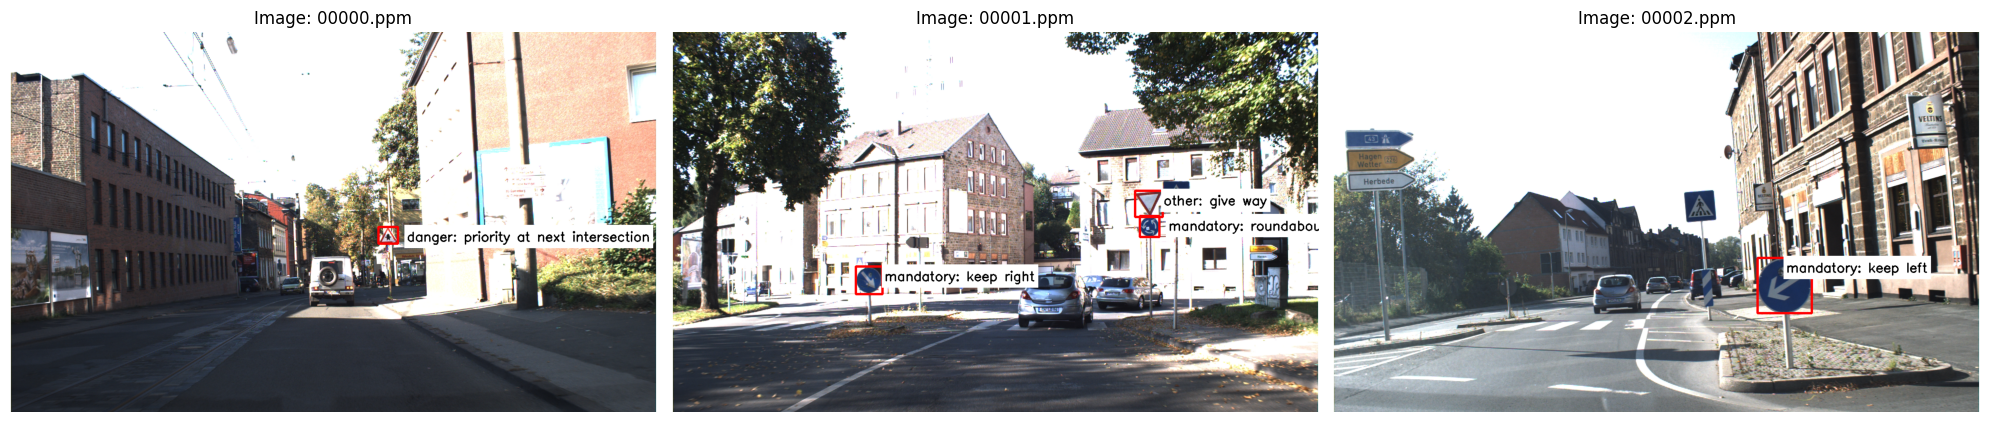

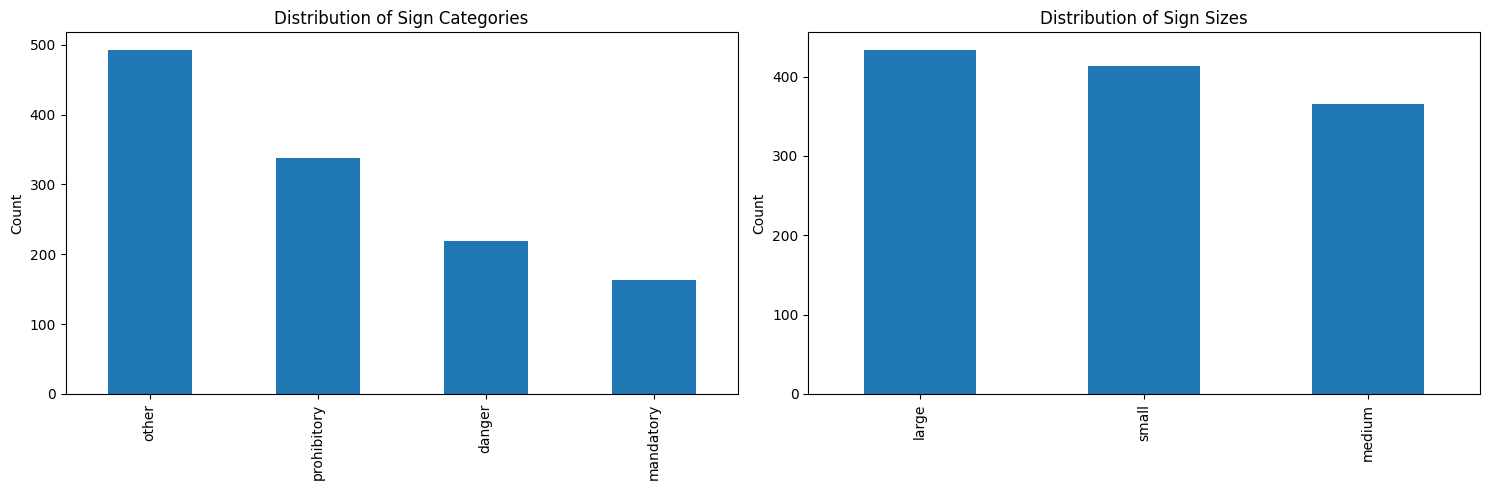


Category Distribution:
other          493
prohibitory    338
danger         219
mandatory      163
Name: count, dtype: int64

Size Distribution:
large     434
small     413
medium    366
Name: count, dtype: int64


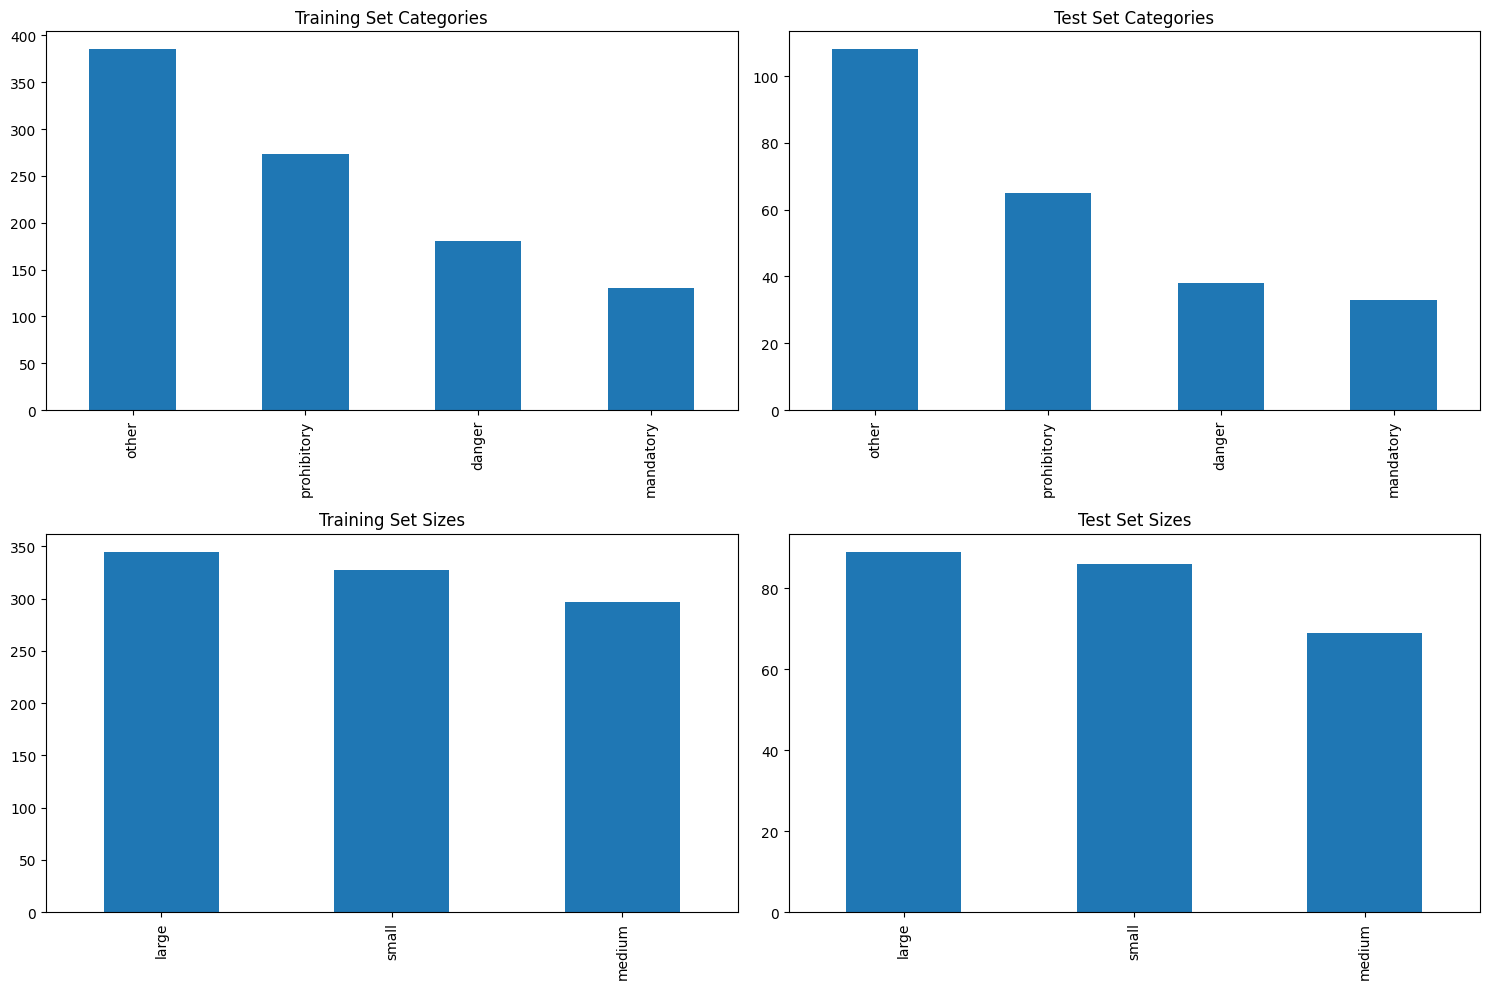

['00121.ppm', '00199.ppm', '00355.ppm', '00689.ppm', '00423.ppm', '00701.ppm', '00076.ppm', '00450.ppm', '00426.ppm', '00317.ppm', '00624.ppm', '00347.ppm', '00896.ppm', '00515.ppm', '00151.ppm', '00384.ppm', '00081.ppm', '00167.ppm', '00101.ppm', '00039.ppm', '00467.ppm', '00379.ppm', '00255.ppm', '00387.ppm', '00772.ppm', '00542.ppm', '00216.ppm', '00295.ppm', '00483.ppm', '00818.ppm', '00077.ppm', '00201.ppm', '00742.ppm', '00898.ppm', '00078.ppm', '00066.ppm', '00393.ppm', '00184.ppm', '00520.ppm', '00033.ppm', '00732.ppm', '00435.ppm', '00884.ppm', '00741.ppm', '00224.ppm', '00425.ppm', '00488.ppm', '00010.ppm', '00841.ppm', '00065.ppm', '00119.ppm', '00725.ppm', '00570.ppm', '00097.ppm', '00564.ppm', '00054.ppm', '00297.ppm', '00408.ppm', '00857.ppm', '00723.ppm', '00635.ppm', '00134.ppm', '00482.ppm', '00619.ppm', '00231.ppm', '00422.ppm', '00456.ppm', '00869.ppm', '00468.ppm', '00217.ppm', '00158.ppm', '00374.ppm', '00072.ppm', '00211.ppm', '00386.ppm', '00161.ppm', '00063.ppm'

In [ ]:
# Initialize dataset with your paths
dataset = GTSDBDataset(
    image_dir="/content/drive/MyDrive/GTSDB/FullIJCNN2013/",  # Replace with your image directory path
    gt_file="/content/drive/MyDrive/GTSDB/FullIJCNN2013/gt.txt"     # Replace with your gt.txt file path
)

# Visualize samples
dataset.visualize_samples()

# Analyze distributions
dataset.analyze_distributions()

# Create and analyze train/test split
dataset.create_train_test_split()